### Correlating Memorization and T-Error in CIFAR100

In this notebook, we will explore the memorization scores and t-error for samples from CIFAR100. We can split our samples into 4 groups: IN/OUT of influence estimation training data + MEMBER/NONMEMBER of diffusion model training corpus.

We focus on the IN influence training data examples, since we have memorization scores for those samples. The null hypothesis (H_0) is that memorization value does not correlate to t-error (reconstruction error).

My guess is that MEMBER samples with higher memorization value should exhibit lower t-error (i.e. be reconstructed better). I think there will be no correlation for NONMEMBER samples, since they couldn't be memorized at all by the diffusion model.

In [2]:
import numpy as np
import json
import pandas as pd

# Load the memorization data
data = np.load('influence-estimates/cifar100_infl_matrix.npz')
tr_mem = data['tr_mem']

# Create a pandas dataframe with memorization scores
df_mem = pd.DataFrame({'image_id': np.arange(0, 50000), 'memorization_score': tr_mem})

# Load the t-error data for members
with open('t_errors/cifar100/member_results.json', 'r') as f:
    t_error_data_member = json.load(f)

# Convert t-error data for members to a DataFrame
t_error_df_member = pd.DataFrame(t_error_data_member)
t_error_df_member['diffusion_member'] = True

# Load the t-error data for non-members
with open('t_errors/cifar100/nonmember_results.json', 'r') as f:
    t_error_data_nonmember = json.load(f)

# Convert t-error data for non-members to a DataFrame
t_error_df_nonmember = pd.DataFrame(t_error_data_nonmember)
t_error_df_nonmember['diffusion_member'] = False

# Combine member and non-member t-error data
t_error_df = pd.concat([t_error_df_member, t_error_df_nonmember], ignore_index=True)

# Merge the t-error data with the memorization scores DataFrame
df = df_mem.merge(t_error_df, on='image_id', how='left').set_index('image_id')


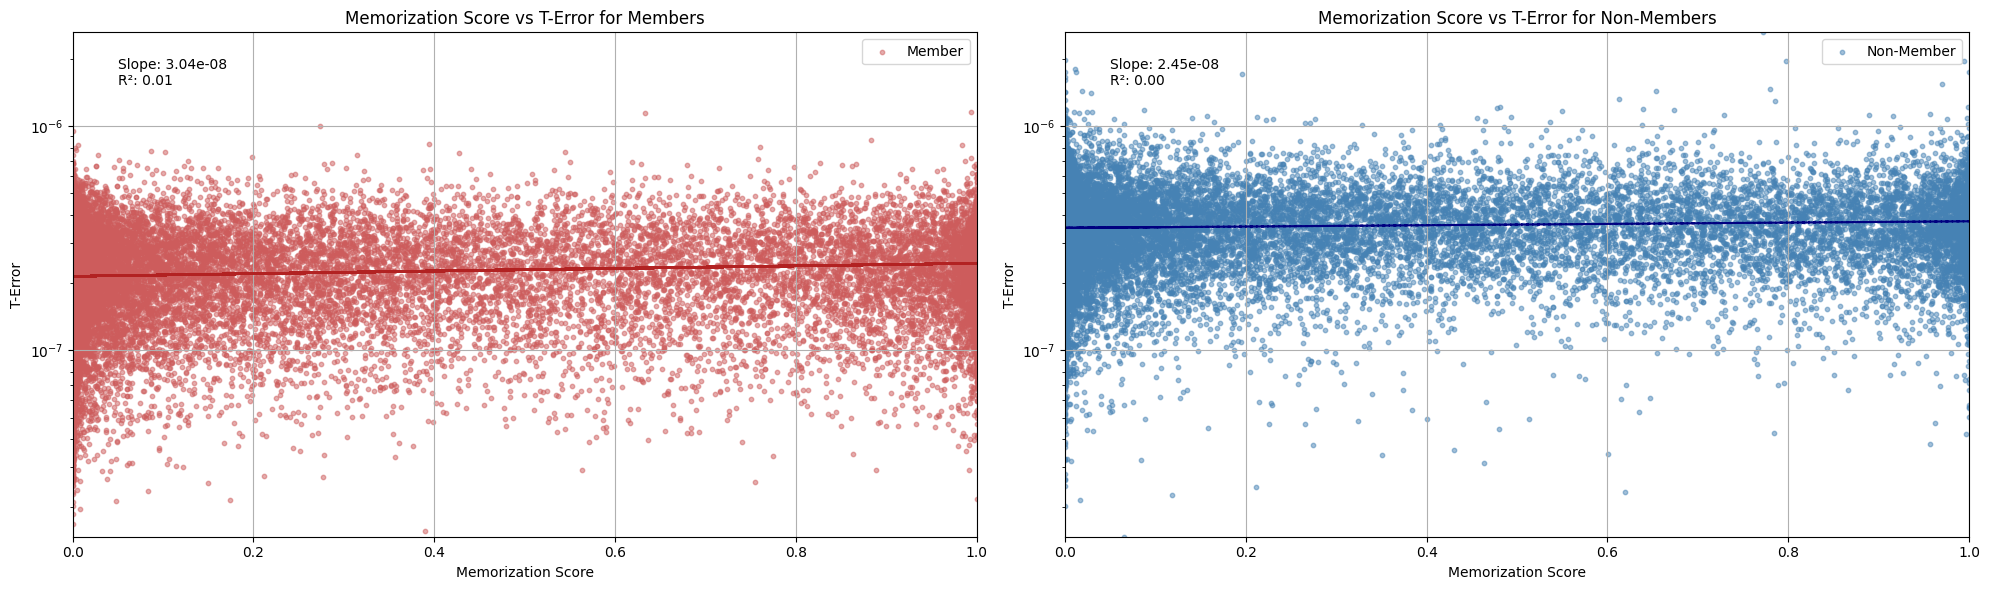

In [4]:
from scipy.stats import linregress

import matplotlib.pyplot as plt

# Filter the dataframe for diffusion_member == True and False
df_member_true = df[df['diffusion_member'] == True]
df_member_false = df[df['diffusion_member'] == False]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Scatter plot for members
axes[0].scatter(df_member_true['memorization_score'], df_member_true['t_error'], alpha=0.5, label='Member', color='indianred', s=10)
m_true, b_true = np.polyfit(df_member_true['memorization_score'], df_member_true['t_error'], 1)
axes[0].plot(df_member_true['memorization_score'], m_true * df_member_true['memorization_score'] + b_true, color='firebrick', linestyle='--')
axes[0].set_title('Memorization Score vs T-Error for Members')
axes[0].set_xlabel('Memorization Score')
axes[0].set_ylabel('T-Error')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True)

# Calculate R² for members
slope, intercept, r_value, p_value, std_err = linregress(df_member_true['memorization_score'], df_member_true['t_error'])
axes[0].text(0.05, 0.95, f'Slope: {slope:.2e}\nR²: {r_value**2:.2f}', transform=axes[0].transAxes, verticalalignment='top')

# Scatter plot for non-members
axes[1].scatter(df_member_false['memorization_score'], df_member_false['t_error'], alpha=0.5, label='Non-Member', color='steelblue', s=10)
m_false, b_false = np.polyfit(df_member_false['memorization_score'], df_member_false['t_error'], 1)
axes[1].plot(df_member_false['memorization_score'], m_false * df_member_false['memorization_score'] + b_false, color='navy', linestyle='--')
axes[1].set_title('Memorization Score vs T-Error for Non-Members')
axes[1].set_xlabel('Memorization Score')
axes[1].set_ylabel('T-Error')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True)

# Calculate R² for non-members
slope, intercept, r_value, p_value, std_err = linregress(df_member_false['memorization_score'], df_member_false['t_error'])
axes[1].text(0.05, 0.95, f'Slope: {slope:.2e}\nR²: {r_value**2:.2f}', transform=axes[1].transAxes, verticalalignment='top')

# Set the same scale for both graphs
x_limits = [min(df['memorization_score']), max(df['memorization_score'])]
y_limits = [min(df['t_error']), max(df['t_error'])]

for ax in axes:
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

plt.tight_layout()
plt.show()